# Brexit Polarity Tweets - Preprocessing

## Setup

In [1]:
import re
import nltk
import string

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP Tools
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation

# ML Tools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder

In [2]:
# define helper functions
def plot_freqdist(freqdist, n = 30):
    """Plot n-most frequent tokens of a FreqDist"""
    plt.figure(figsize=(12,3))
    freqdist.plot(n)
    plt.show()

def extend_stopwords(stopwords):
    """Extend stopwords with lemmatized words"""
    lemmatized_stopwords = [lemmatizer.lemmatize(word) for word in stopwords]
    stopwords = stopwords + lemmatized_stopwords
    return stopwords

In [3]:
# make shortcut and set seed for numpy random generator
rd = np.random
rd.seed(123)

# specify some NLP-related functions 
label_encoder = LabelEncoder()
tokenizer     = TweetTokenizer()
lemmatizer    = WordNetLemmatizer()
sia           = SentimentIntensityAnalyzer()

# specify unwanted tokens to be filtered in cleaning process
stopwords       = nltk.corpus.stopwords.words('english')
unwanted_tokens = ["…", "...", "..", "\xad", "–"]
unwanted_tokens += extend_stopwords(stopwords) + list(string.punctuation)

In [4]:
# settings
N_ROWS     = 1_000 # `None` to import all rows
N_FEATURES = 10 # for each feature groups (i.e., hashtags, tokens, counts, tf-idf)
TEST_SPLIT = 0.2
PATH_DATA  = "./data/"

# paths to raw data
PATH_ANTI  = PATH_DATA + 'raw/TweetDataset_AntiBrexit_Jan-Mar2022.csv'
PATH_PRO   = PATH_DATA + 'raw/TweetDataset_ProBrexit_Jan-Mar2022.csv'

# paths to processed data
PATH_TARGETS      = PATH_DATA + "preprocessed/targets.csv"
PATH_TWEETS_RAW   = PATH_DATA + "preprocessed/tweets_raw.csv"
PATH_TWEETS_TOKEN = PATH_DATA + "preprocessed/tweets_token.csv"

# paths to extracted features
PATH_X_TRAIN = PATH_DATA + "features/X_train.csv"
PATH_X_TEST  = PATH_DATA + "features/X_test.csv"
PATH_Y_TRAIN = PATH_DATA + "features/y_train.csv"
PATH_Y_TEST  = PATH_DATA + "features/y_test.csv"

# Data Preparation

## Import

In [5]:
# view data
pro  = pd.read_csv(PATH_PRO, nrows = 1)
anti = pd.read_csv(PATH_ANTI, nrows = 1)

pd.concat([pro, anti])

,Unnamed: 0,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,...,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags
0,0,15-Jan-2022 11:58PM,NaN,https://twitter.com/dianemcgregor8/statuses/14...,NaN,RT @re11ddy: QT @sandieshoes: Do this if you v...,Twitter,@dianemcgregor8,Cameroon,NaN,...,Diane M McGregor,https://twitter.com/dianemcgregor8,Veggie burger! Lover of all Animals and Nature...,122.0,185.0,"Jan 15, 2022",11:58 PM,North,NaN,NaN
0,0,09-Jan-2022 11:58PM,NaN,https://twitter.com/nickynicky77551/statuses/1...,NaN,"RT @cnapan: #JohnsonOut is now running at 218,...",Twitter,@nickynicky77551,Unknown,NaN,...,nicky@nicky7755,https://twitter.com/nickynicky77551,"Ardent Remainer; Rejoiner now, Support NHS 💙 #...",1697.0,2576.0,"Jan 9, 2022",11:58 PM,NaN,NaN,NaN


In [6]:
# import both pro and anti tweets data

if N_ROWS is not None:
    nrows = N_ROWS // 2
else:
    nrows = None

pro  = pd.read_csv(PATH_PRO, nrows = nrows)["Hit Sentence"]
anti = pd.read_csv(PATH_ANTI, nrows = nrows)["Hit Sentence"]

# combine all tweets data and create targets variable
tweets = pd.concat([pro, anti]).reset_index(drop = True)
targets = pd.Series(np.repeat(["Pro", "Anti"], [len(pro), len(anti)]))

# count the total number of tweets
tweets_length = len(pro) + len(anti)

print(f"There are {len(pro)} tweets from users who support Brexit")
print(f"There are {len(anti)} tweets from users who doesn't support Brexit")

# delete unused variables
del pro, anti

There are 500 tweets from users who support Brexit
There are 500 tweets from users who doesn't support Brexit


In [7]:
# observe top 5 tweets
for i, tweet in enumerate(tweets[:5]): print(f"Tweet {i}:  {tweet}")

Tweet 0:  RT @re11ddy: QT @sandieshoes: Do this if you value Brexit ; Tory MPs are back in their constituencies this weekend. Can you contact them as they contemplate if they should put a letter into the 1922. It would just take a few minutes. Their email details are easily found. Don’t lay down in front of the media. Please act. #BackBoris
Tweet 1:  RT @RickSacrop: Michael Fabricant is absolutely right. How can it be 'dangerous' to expose what is obvious to most people. The MSM and particularly the BBC are hell bent on getting shot of Boris because he removed from us their precious EU. There is no place for revenge propaganda in the UK.
Tweet 2:  @StokieDrew2 I do find it rich; that Tory voters who I assume are Unionists/Conservatives; are oblivious that a part of i and your United Kingdom has been betrayed by the Johnson leadership; while Boasting that Brexit is done. It's not done until EU have no legitimacy over Northern Ireland. https://t.co/KHrWBrLQhB
Tweet 3:  RT @denistmurray: 

## Clean Tweets

In [8]:
def clean_tweet(tweet):
    """Clean all tweets from RT, QT, URLs, HTML Tags, numbers and statistics, emojis, and unicode punctuation marks"""
    
    # Regex for removing "RT" or "QT"
    qt_rt = re.compile(r'(RT|QT)? ?@[\w]+:?')

    # Regex for removing URL
    url = re.compile(r'https?://\S+')

    # Regex for removing HTML tags
    # source of regex: https://stackoverflow.com/a/12982689
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

    # Regex for removing numbers and statistics
    currency = re.compile(r'[$|£].?[0-9]*(,?[0-9]{3})*(\.[0-9]*)*')
    percent = re.compile(r'[0-9]*(,?[0-9]{3})*(\.[0-9]*)*%')
    ordinals = re.compile(r'[0-9]+(,?[0-9]{3})*(st|nd|rd|th)')
    fractions = re.compile(r'[0-9]+/[0-9]+')

    # Regex for removing emojis
    # Source of regex: https://stackoverflow.com/a/58356570
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)

    # Regex for replacing unicode quotation marks into regular one
    single_quotation = re.compile(u"[\u2018|\u2019]", flags = re.UNICODE)
    double_quotation = re.compile(u"[\u201c|\u201d]", flags = re.UNICODE)
    
    tweet = re.sub(qt_rt, "", tweet)
    tweet = re.sub(url, "", tweet)
    tweet = re.sub(html, "", tweet)
    tweet = re.sub(currency, "", tweet)
    tweet = re.sub(percent, "", tweet)
    tweet = re.sub(ordinals, "", tweet)
    tweet = re.sub(fractions, "", tweet)
    tweet = re.sub(emojis, "", tweet)
    tweet = re.sub(single_quotation, "'", tweet)
    tweet = re.sub(double_quotation, "\"", tweet)
    tweet = re.sub(" +", " ", tweet).strip()
    
    return tweet

In [9]:
# observe top 5 tweets
for i, tweet in enumerate(tweets[:5]): print(f"Tweet {i}:  {clean_tweet(tweet)}")

Tweet 0:  Do this if you value Brexit ; Tory MPs are back in their constituencies this weekend. Can you contact them as they contemplate if they should put a letter into the 1922. It would just take a few minutes. Their email details are easily found. Don't lay down in front of the media. Please act. #BackBoris
Tweet 1:  Michael Fabricant is absolutely right. How can it be 'dangerous' to expose what is obvious to most people. The MSM and particularly the BBC are hell bent on getting shot of Boris because he removed from us their precious EU. There is no place for revenge propaganda in the UK.
Tweet 2:  I do find it rich; that Tory voters who I assume are Unionists/Conservatives; are oblivious that a part of i and your United Kingdom has been betrayed by the Johnson leadership; while Boasting that Brexit is done. It's not done until EU have no legitimacy over Northern Ireland.
Tweet 3:  Brexit Britain win as London named best city for young businesses : Excellent for Brexit and the UK F

## Tokenized Tweets

In [10]:
def tokenize_tweet(tweet):
    """Tokenize a given tweet while removing unwanted tokens and lemmatizing each token"""
    
    output = []
    
    # mark tokens when it is in negative context
    tokens = mark_negation([t for t in tokenizer.tokenize(tweet.lower())])
    
    for token in tokens:
        # do not include token if it is not relevant
        if token.replace("_NEG", "") in unwanted_tokens: continue
        
        # extract alphabets from the token
        t = "".join(re.findall(r"[A-z]+", token))

        # lemmatize token
        t = lemmatizer.lemmatize(t)
        
        # only add token if it is not an empty string
        if len(t) != 0 and len(t.replace("_NEG", "")) != 0:
            output.append(t)

    return output

In [11]:
# observe top 5 tweets
for i, tweet in enumerate(tweets[:5]): 
    tweet = clean_tweet(tweet)
    tweet = tokenize_tweet(tweet)
    print(f"Tweet {i}:  {tweet}")

Tweet 0:  ['value', 'brexit', 'tory', 'mp', 'back', 'constituency', 'weekend', 'contact', 'contemplate', 'put', 'letter', 'would', 'take', 'minute', 'email', 'detail', 'easily', 'found', 'lay_NEG', 'front_NEG', 'media_NEG', 'please', 'act', 'backboris']
Tweet 1:  ['michael', 'fabricant', 'absolutely', 'right', 'dangerous', 'expose', 'obvious', 'people', 'msm', 'particularly', 'bbc', 'hell', 'bent', 'getting', 'shot', 'boris', 'removed', 'u', 'precious', 'eu', 'place_NEG', 'revenge_NEG', 'propaganda_NEG', 'uk_NEG']
Tweet 2:  ['find', 'rich', 'tory', 'voter', 'assume', 'unionist', 'conservative', 'oblivious', 'part', 'united', 'kingdom', 'betrayed', 'johnson', 'leadership', 'boasting', 'brexit', 'done', 'done_NEG', 'eu_NEG', 'legitimacy_NEG', 'northern_NEG', 'ireland_NEG']
Tweet 3:  ['brexit', 'britain', 'win', 'london', 'named', 'best', 'city', 'young', 'business', 'excellent', 'brexit', 'uk', 'future']
Tweet 4:  ['johnson', 'taken', 'tory', 'likelihood', 'imposed', 'pm', 'remainer', 'b

## Preprocess Tweets

In [12]:
def preprocess_tweets(tweets, targets):
    """Process all tweet within tweets data using tokenize_tweet function"""
    
    # check if both has the same length
    assert len(tweets) == len(targets)
    
    # clean and tokenize tweets
    tweet_tokens = tweets.map(lambda tweet: tokenize_tweet(clean_tweet(tweet)))
    
    # find indices of tweets with empty token
    non_empty_tweet = tweet_tokens.map(len) != 0

    # remove tweets that has zero tokens after preprocessed based on index
    tweet_tokens = tweet_tokens[non_empty_tweet].reset_index(drop = True)
    tweets       = tweets[non_empty_tweet].reset_index(drop = True)
    targets      = targets[non_empty_tweet].reset_index(drop = True)

    # ensure this process does not change the dimension of data
    assert len(tweets) == len(targets)
    
    return tweets, tweet_tokens, targets

In [13]:
tweets, tweet_tokens, targets = preprocess_tweets(tweets, targets)

In [14]:
print(f"Deleted {tweets_length - len(tweet_tokens)} out of {tweets_length} tweets.", end = " ")

# count the total number of tweets left
tweets_length = len(tweets)

print(f"There are {tweets_length} tweets left.")

Deleted 12 out of 1000 tweets. There are 988 tweets left.


In [15]:
tweets.to_csv(PATH_TWEETS_RAW)
tweet_tokens.to_csv(PATH_TWEETS_TOKEN)
targets.to_csv(PATH_TARGETS)

# Feature Extraction

## Splitting Data

In [16]:
# generate indices to split dataset
sss = ShuffleSplit(n_splits = 1, test_size = TEST_SPLIT, random_state = 123)
sss.get_n_splits(tweet_tokens, targets)

train_index, test_index = next(sss.split(tweet_tokens, targets))

print(f"There are {len(train_index)} tweets in the train dataset.")
print(f"There are {len(test_index)} tweets in the test dataset.")

There are 790 tweets in the train dataset.
There are 198 tweets in the test dataset.


## Feature 1: Hashtags

In [17]:
# create a variable to store frequency distribution based on label
fd_hashtags = nltk.ConditionalFreqDist()

# calculate the frequency of hashtags based on label
for index, tweet in zip(tweets.index, tweets):
    for token in tokenizer.tokenize(tweet):
        if re.match("^#\S+", token):
            condition = targets[index]
            fd_hashtags[condition][token] += 1

# remove shared hashtags for each type of users
common_hashtags = set(fd_hashtags["Pro"]).intersection(fd_hashtags["Anti"])

for token in common_hashtags:
    del fd_hashtags["Pro"][token]
    del fd_hashtags["Anti"][token]

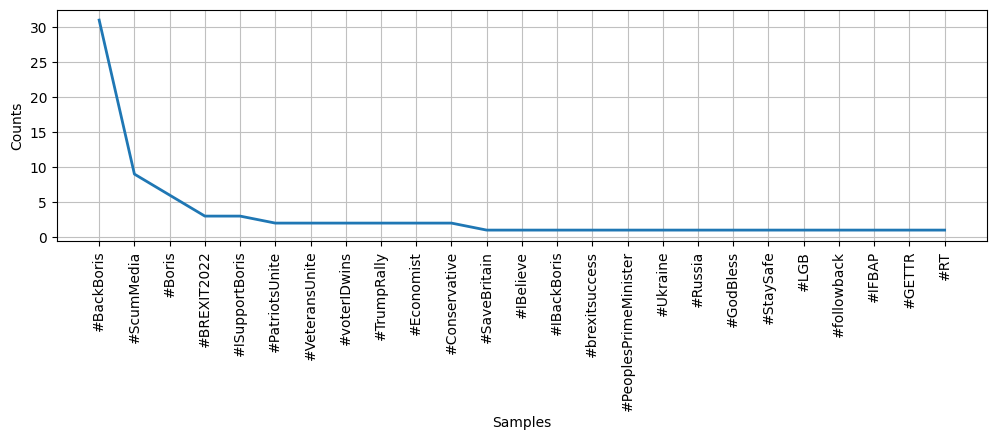

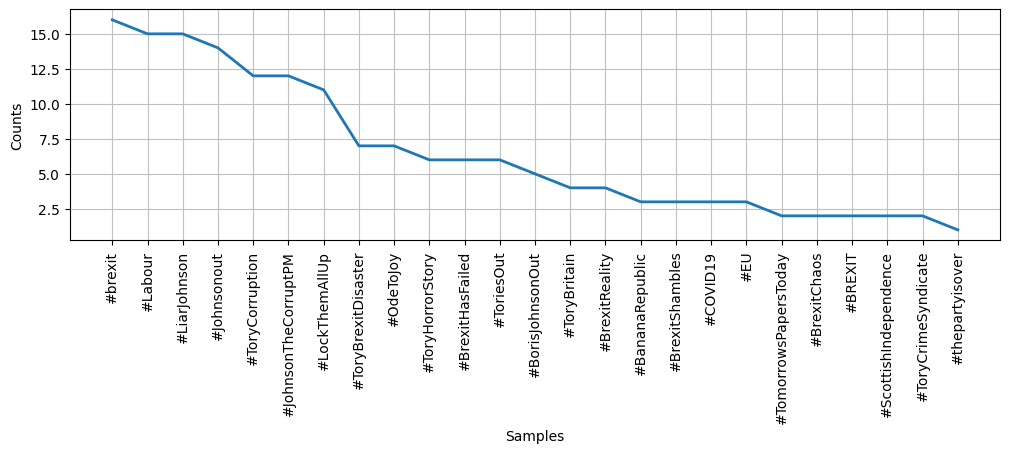

In [18]:
# visualize top hashtags from pro-Brexit users' tweet
plot_freqdist(fd_hashtags["Pro"], n = 25)

# visualize top hashtags from anti-Brexit users' tweet
plot_freqdist(fd_hashtags["Anti"], n = 25)

In [19]:
def extract_hashtags(tweets, fdist = fd_hashtags, n_features = 50):
    # empty list to store features of each tweet
    features = []
    n_each = np.ceil(n_features / 2).astype(int)
    
    # get the most frequent hashtags for each type of users
    top_hashtags_pro  = [t for t, _ in fdist["Pro"].most_common(n_each)]
    top_hashtags_anti = [t for t, _ in fdist["Anti"].most_common(n_each)]
    
    # extract features from all tweets
    for tweet in tweets:
        f = {}
            
        # count the number of top tokens
        tokens = tokenizer.tokenize(tweet)
        f["total_hashtags_pro"]  = np.sum(np.isin(tokens, top_hashtags_pro))
        f["total_hashtags_anti"] = np.sum(np.isin(tokens, top_hashtags_anti))
        f["total_hashtags_all"] = f["total_hashtags_pro"] + f["total_hashtags_anti"]
        
        # if a top token exists gives true, otherwise false
        for token in top_hashtags_pro + top_hashtags_anti: 
            f[f"contains({token})"] = token in tweet
        
        features.append(f)

    return pd.DataFrame(features)

In [20]:
extract_hashtags(tweets[:5], fd_hashtags, 5)

,total_hashtags_pro,total_hashtags_anti,total_hashtags_all,contains(#BackBoris),contains(#ScumMedia),contains(#Boris),contains(#brexit),contains(#Labour),contains(#LiarJohnson)
0,1,0,1,True,False,False,False,False,False
1,0,0,0,False,False,False,False,False,False
2,0,0,0,False,False,False,False,False,False
3,0,0,0,False,False,False,False,False,False
4,0,0,0,False,False,False,False,False,False


## Feature 2: Tokens

In [21]:
# create a variable to store frequency distribution based on label
fd_tokens = nltk.ConditionalFreqDist()

# calculate the frequency of tokens based on label
for index, tokens in zip(tweet_tokens.index, tweet_tokens):
    for token in tokens:
        condition = targets[index]
        fd_tokens[condition][token] += 1


# remove shared tokens for each type of users
common_tokens = set(fd_tokens["Pro"]).intersection(fd_tokens["Anti"])

for token in common_tokens:
    del fd_tokens["Pro"][token]
    del fd_tokens["Anti"][token]

In [22]:
# list all potential tokens that might already be included in the hashtags freqdist
hashtag_token = list(common_hashtags)
hashtag_token = hashtag_token + [h for h in fd_hashtags["Pro"]]
hashtag_token = hashtag_token + [h for h in fd_hashtags["Anti"]]

# adding _NEG to all possible hashtags to accommodate negation
hashtag_token = hashtag_token + [h + "_NEG" for h in hashtag_token] 

# removing the '#' symbol to be able to represent pre-processed tokens
hashtag_token = [h.lower()[1:] for h in hashtag_token] 

# remove tokens that are already in hashtags
for token in fd_tokens["Pro"]:
    if token in hashtag_token:
        del fd_tokens["Pro"][token]

for token in fd_tokens["Anti"]:
    if token in hashtag_token:
        del fd_tokens["Anti"][token]

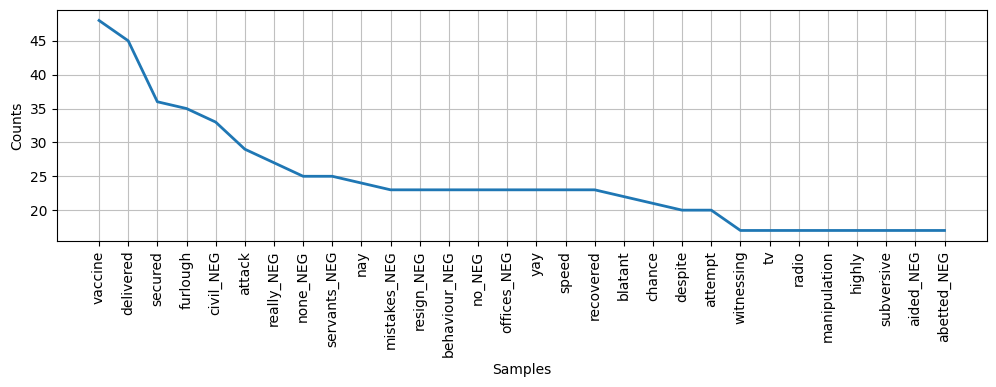

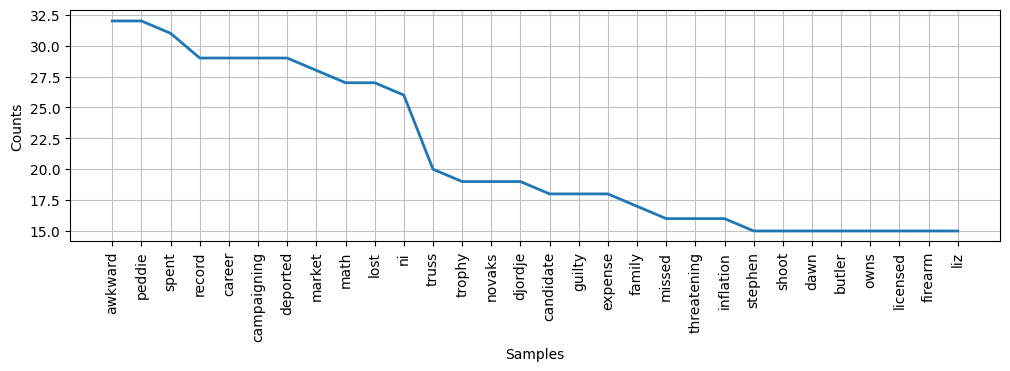

In [23]:
# visualize top tokens from pro-Brexit users' tweet
plot_freqdist(fd_tokens["Pro"])

# visualize top tokens from anti-Brexit users' tweet
plot_freqdist(fd_tokens["Anti"])

In [24]:
def extract_tokens(tweet_tokens, fdist = fd_tokens, n_features = 50):
    # empty list to store features of each tweet
    features = []
    n_each = np.ceil(n_features / 2).astype(int)
    
    # get the most frequent tokens for each type of users
    top_tokens_pro  = [t for t, _ in fdist["Pro"].most_common(n_each)]
    top_tokens_anti = [t for t, _ in fdist["Anti"].most_common(n_each)]
    
    # extract feature from all tweets
    for tweet in tweet_tokens:
        f = {}
        
        # count the number of top tokens
        f["total_tokens_pro"]  = np.sum(np.isin(tweet_tokens, top_tokens_pro))
        f["total_tokens_anti"] = np.sum(np.isin(tweet_tokens, top_tokens_anti))
        f["total_tokens_all"] = f["total_tokens_pro"] + f["total_tokens_anti"]
        
        # if a top token exists gives true, otherwise false
        for token in top_tokens_pro + top_tokens_anti: 
            f[f"contains({token})"] = token in tweet_tokens
        
        features.append(f)

    return pd.DataFrame(features)

In [25]:
extract_tokens(tweet_tokens[:5], fd_tokens, 5)

,total_tokens_pro,total_tokens_anti,total_tokens_all,contains(vaccine),contains(delivered),contains(secured),contains(awkward),contains(peddie),contains(spent)
0,0,0,0,False,False,False,False,False,False
1,0,0,0,False,False,False,False,False,False
2,0,0,0,False,False,False,False,False,False
3,0,0,0,False,False,False,False,False,False
4,0,0,0,False,False,False,False,False,False


## Feature 3: TF and TF-IDF

In [26]:
def extract_counts(tweet_tokens, fdist = fd_tokens, n_features = 50):
    n_each = np.ceil(n_features / 2).astype(int)
    
    vocabs = [token for token, count in fdist["Anti"].most_common(n_each)]
    vocabs += [token for token, count in fdist["Pro"].most_common(n_each)]
    
    count_vectorizer = CountVectorizer(input = "content",
                                       token_pattern = None,
                                       tokenizer = lambda doc: doc,
                                       preprocessor = lambda doc:doc,
                                       vocabulary = vocabs,
                                       lowercase = False)
    
    token_names = count_vectorizer.get_feature_names_out()
    
    counts = count_vectorizer.fit_transform(tweet_tokens).toarray()
    
    return pd.DataFrame(counts, columns = f"count(" + token_names + ")")

In [27]:
extract_counts(tweet_tokens[:5], fd_tokens, 10) # the data is sparse

,count(awkward),count(peddie),count(spent),count(record),count(career),count(vaccine),count(delivered),count(secured),count(furlough),count(civil_NEG)
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [28]:
def extract_tfidfs(tweet_tokens, fdist = fd_tokens, n_features = 50):
    n_each = np.ceil(n_features / 2).astype(int)
    
    vocabs = [token for token, count in fdist["Anti"].most_common(n_each)]
    vocabs += [token for token, count in fdist["Pro"].most_common(n_each)]
    
    tfidf_vectorizer = TfidfVectorizer(input = "content",
                                       token_pattern = None,
                                       tokenizer = lambda doc: doc,
                                       preprocessor = lambda doc:doc,
                                       vocabulary = vocabs,
                                       lowercase = False)
    
    token_names = tfidf_vectorizer.get_feature_names_out()
    tfidfs = tfidf_vectorizer.fit_transform(tweet_tokens).toarray()
    return pd.DataFrame(tfidfs, columns = "tfidf(" + token_names + ")")

In [29]:
extract_tfidfs(tweet_tokens[:5], fd_tokens, 10) # the data is sparse

,tfidf(awkward),tfidf(peddie),tfidf(spent),tfidf(record),tfidf(career),tfidf(vaccine),tfidf(delivered),tfidf(secured),tfidf(furlough),tfidf(civil_NEG)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature 4: Sentiments

In [30]:
def exctract_sentiments(tweets):
    # empty list to store features of each tweet
    features = []
    
    for tweet in tweets:
        f = {}
        
        # calculate the average polarity scores for each tweet
        sentiment_cmp = []
        sentiment_pos = []
        sentiment_neg = []
        sentiment_neu = []
        
        # calculate each sentence's sentiment in each tweet
        for s in nltk.sent_tokenize(tweet):
            sentiment_cmp.append(sia.polarity_scores(s)["compound"])
            sentiment_pos.append(sia.polarity_scores(s)["pos"])
            sentiment_neg.append(sia.polarity_scores(s)["neg"])
            sentiment_neu.append(sia.polarity_scores(s)["neu"])

        f["sentiment_compound"] = np.mean(sentiment_cmp)
        f["sentiment_positive"] = np.mean(sentiment_pos)
        f["sentiment_negative"] = np.mean(sentiment_neg)
        f["sentiment_neutral"] = np.mean(sentiment_neu)
        
        features.append(f)

    return pd.DataFrame(features)

In [31]:
exctract_sentiments(tweets[:5])

,sentiment_compound,sentiment_positive,sentiment_negative,sentiment_neutral
0,0.195814,0.182857,0.000000,0.817143
1,-0.286100,0.032750,0.200500,0.767000
2,0.014667,0.051667,0.092333,0.856333
3,0.913600,0.394000,0.000000,0.606000
4,-0.255600,0.054000,0.196333,0.750000


## Combining All Features 

In [32]:
def extract_all_features(tweets_raw,
                         tweet_tokens,
                         indices,
                         fd_tokens = fd_tokens,
                         fd_hashtags = fd_hashtags,
                         n_features = 50):
    
    ft_hashtags   = extract_hashtags(tweets_raw, fd_hashtags, n_features)
    ft_tokens     = extract_tokens(tweet_tokens, fd_tokens, n_features)
    ft_counts     = extract_counts(tweet_tokens, fd_tokens, n_features)
    ft_tfidfs     = extract_tfidfs(tweet_tokens, fd_tokens, n_features)
    ft_sentiments = exctract_sentiments(tweets_raw)
    
    return pd.concat([ft_hashtags, ft_tokens, ft_counts, ft_tfidfs, ft_sentiments], axis = 1)

In [33]:
X_train = extract_all_features(tweets[train_index], tweet_tokens[train_index], train_index, n_features = N_FEATURES)
X_test  = extract_all_features(tweets[test_index], tweet_tokens[test_index], test_index, n_features = N_FEATURES)

y_train = label_encoder.fit_transform(targets[train_index])
y_test  = label_encoder.transform(targets[test_index])

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((790, 50), (790,), (198, 50), (198,))

In [35]:
X_train.to_csv(PATH_X_TRAIN, index = False)
X_test.to_csv(PATH_X_TEST, index = False)

pd.Series(y_train).to_csv(PATH_Y_TRAIN, index = False)
pd.Series(y_test).to_csv(PATH_Y_TEST, index = False)

In [36]:
assert (pd.read_csv(PATH_Y_TRAIN).values.flatten() == y_train).all()
assert (np.abs(pd.read_csv(PATH_X_TRAIN)["sentiment_compound"] - X_train["sentiment_compound"]) < 0.000001).all()